# Prepare Workspace

## Install required modules

In [1]:
#!pip install -U -q PyDrive
#!pip install geopandas

## Load required modules

In [2]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats

#from google.colab import data_table
#data_table.enable_dataframe_formatter()
from sklearn.preprocessing import MinMaxScaler

# https://scikit-learn.org/stable/modules/impute.html
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#from sklearn.linear_model import LinearRegression
#from scipy.optimize import linprog


#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#from google.colab import files

In [3]:
import geopandas as gpd

## Load files
### COVID-19_Vaccinations_in_the_United_States_County.csv'


In [4]:
df =pd.read_csv('COVID-19_Vaccinations_in_the_United_States_County.csv')

/state/partition1/slurm_tmp/22601130.0.0/ipykernel_13646/1897075600.py:1: DtypeWarning: Columns (6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,67,68,71,72,74,76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv('COVID-19_Vaccinations_in_the_United_States_County.csv')


### ACS, SVI, Medical Facilities

In [5]:
acs = pd.read_csv('ACS.csv')
svi = pd.read_csv('SVI2020_US_COUNTY.csv')

In [6]:
facilities = pd.read_csv("medical_facilities_counties.csv")#gpd.read_file("./Counties_Medical_Facilities/Counties_Medical_Facilities.shp")

In [7]:
facilities = facilities[["FIPS", "Point Coun"]].copy()

In [8]:
transportation = gpd.read_file("../Counties_Transportation/Counties_Transportation.shp", include_fields=["FIPS", "Point_Coun"])

In [9]:
transportation = transportation[["FIPS", "Point_Coun"]].copy()

# Prepare Data

## Select relevant columns only

In [10]:
df["Date"] = pd.to_datetime(df["Date"])
df["YYYYWW"] = df["Date"].dt.year*100 + df["MMWR_week"]

df2 = df[[#'Date',
 'FIPS',
 #'MMWR_week',
 #'Recip_County',
 #'Recip_State',
 'Completeness_pct',
 "YYYYWW"]]

In [11]:
# Free up some memory
df = None

In [12]:
# For checks only
mask = df2["FIPS"]  == "202051"
df2[mask]

,FIPS,Completeness_pct,YYYYWW


## Aggregate on week level

In [13]:
df2 = df2.set_index(["FIPS", "YYYYWW"])
df2.reset_index(inplace=True)
df_pivot = df2.pivot_table(columns=['FIPS'], aggfunc=np.mean, index="YYYYWW").copy()
df_pivot.sort_values("YYYYWW", ascending=True, inplace=True)

## Calculate the time how long it took to attain the maximum coverage level

In [14]:
# create a function to calculate the time it takes to reach the maximum value
def calculate_time_to_reach_max(series):
    return (series == series.max()).idxmax()

# create a function to calculate the time it takes to reach the target value
# specify the target value
target = 8

def calculate_time_to_reach_target(series):
    return (series == target).idxmax()

### Cacultate values
Also introduced an index:
Weeks to max / Max. Completeness to account for speed and highest percentage.

In [15]:
scaler = MinMaxScaler()

In [16]:
# apply the function to each column (time series) in the dataframe
df_result = pd.DataFrame()#index=list(df_pivot))
df_result["W"] = df_pivot.apply(calculate_time_to_reach_max)
df_result["MAX_Completeness_pct"] = df_pivot.max()/100

mask = df_result["MAX_Completeness_pct"] == 0
start_week = df_result[~mask]["W"].min() #min(df_pivot.Completeness_pct.index)
offset = -1

df_result["Weeks2MAX"] = df_result["W"] - start_week - offset
df_result[["Weeks2MAX"]] = scaler.fit_transform(df_result[["Weeks2MAX"]])
df_result["IDX_W2M"] = df_result["Weeks2MAX"]/df_result["MAX_Completeness_pct"]

### Drop those without reliable data

In [17]:
df_result.drop(df_result[mask].index, inplace=True)

In [18]:
df_result = df_result.droplevel(0)#.reset_index("FIPS")
df_result.replace([np.inf, -np.inf], np.nan, inplace=True)
df_result.dropna(inplace = True)

### Results:

array([[<AxesSubplot:title={'center':'W'}>,
        <AxesSubplot:title={'center':'MAX_Completeness_pct'}>],
       [<AxesSubplot:title={'center':'Weeks2MAX'}>,
        <AxesSubplot:title={'center':'IDX_W2M'}>]], dtype=object)

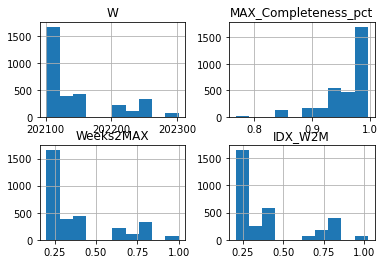

In [19]:
df_result.hist()

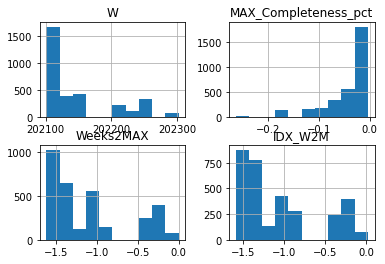

In [26]:
df_log = df_result
df_log[['MAX_Completeness_pct', 'Weeks2MAX', 'IDX_W2M']] = df_result[['MAX_Completeness_pct', 'Weeks2MAX', 'IDX_W2M']].apply(np.log)
#np.log(data['Salary'])
df_log.hist()
df_result['IDX_W2M'] = df_log['IDX_W2M']

<AxesSubplot:>

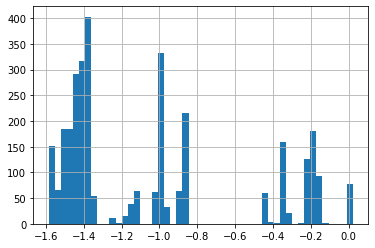

In [21]:
df_log['IDX_W2M'].hist(bins=50)

In [29]:
df_log['IDX_W2M'].max()-df_log['IDX_W2M'].min()

1.6082726780102086

In [30]:
df_log['IDX_W2M'].max()

0.022245608947319737

In [31]:
df_log['IDX_W2M'].min()

-1.5860270690628888

In [24]:
df_result

,W,MAX_Completeness_pct,Weeks2MAX,IDX_W2M
FIPS,,,,
01001,202110,0.940286,0.235060,0.249988
01003,202102,0.946143,0.203187,0.214753
01005,202110,0.940286,0.235060,0.249988
01007,202110,0.940286,0.235060,0.249988
01009,202110,0.940286,0.235060,0.249988
...,...,...,...,...
72153,202302,0.978000,1.000000,1.022495
78010,202247,0.872000,0.780876,0.895501
78020,202247,0.872000,0.780876,0.895501


In [22]:
df_result.shape

(3212, 4)

In [23]:
df_result.to_csv("df_result.csv")
#files.download("df_result.csv")

In [24]:
## For checks only
#mask = df2["FIPS"]  == "25017"
#df2[mask].groupby("YYYYWW").mean().round(1)

# Join with ACS and SVI

## join with ACS

In [25]:
acs["State Postal Abbreviation"].unique()

array(['Geo_STUSAB', 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'dc',
       'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me',
       'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj',
       'nm', 'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd',
       'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'pr'],
      dtype=object)

In [26]:
mask = ((acs["State Postal Abbreviation"]!="ak") & (acs["State Postal Abbreviation"]!="hi"))
#ak=Alaska, hi=Hawaii

In [27]:
mask

0       True
1       True
2       True
3       True
4       True
        ... 
3217    True
3218    True
3219    True
3220    True
3221    True
Name: State Postal Abbreviation, Length: 3222, dtype: bool

In [28]:
acs = acs[mask]

In [29]:
acs["State Postal Abbreviation"].unique()

array(['Geo_STUSAB', 'al', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'dc', 'fl',
       'ga', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
       'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
       'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'pr'], dtype=object)

In [30]:
df=acs.set_index('FIPS').join(df_result)#.set_index('FIPS'))
df = df.sort_values(by="FIPS", ascending=False)
df=df.reset_index()

In [31]:
#np.issubdtype(df["FIPS"].dtype, np.number)
#df[["FIPS"]].applymap(np.isreal)
#df[["FIPS"]].applymap(lambda x: isinstance(int(x), (int, float)))

In [32]:
df.drop(0, inplace=True)

## join with SVI

In [33]:
svi.replace([-999], np.nan, inplace=True) # -999 encodes NAN

In [34]:
numeric_cols = list(svi.select_dtypes(include="number"))

In [35]:
svi_imputed = svi.copy()

In [36]:
#imp = IterativeImputer(missing_values=-999, max_iter=10, random_state=0)
#imp.fit(svi[numeric_cols])
#IterativeImputer(random_state=0)
#svi_imputed[numeric_cols] = imp.transform(svi[numeric_cols])

In [37]:
df['FIPS']=df['FIPS'].astype('int64')
df_merged=df.set_index('FIPS').join(svi_imputed.set_index('FIPS'))

In [38]:
df_merged_copy = df_merged.copy()
df_merged = df_merged_copy.copy()

### join with medical facilities

In [39]:
#df_merged['County of current residence']=df_merged['County of current residence'].astype('int64').copy()
facilities['FIPS']=facilities['FIPS'].astype('int64').copy()

In [40]:
#df_merged.reset_index(inplace=True)

In [41]:
df_merged=df_merged.join(facilities.set_index('FIPS'))

In [42]:
rename = {'Point Coun': "Count_Medical_Facilities"}
df_merged.rename(columns=rename, inplace=True)
df_merged.reset_index(inplace=True)

In [43]:
df_merged["Count_Medical_Facilities"].isna().sum()

122

In [44]:
df_merged["Count_Medical_Facilities"].replace([np.nan], 0, inplace=True)

In [45]:
df_merged_copy = df_merged.copy()
df_merged = df_merged_copy.copy()

In [46]:
df_merged["Count_Medical_Facilities"].sum()

177766.0

In [47]:
facilities["Point Coun"].sum()

179003.0

### join transportation

In [48]:
transportation['FIPS']=transportation['FIPS'].astype('int64').copy()

In [49]:
df_merged = df_merged.set_index("FIPS").join(transportation.set_index('FIPS'))
rename    = {'Point_Coun': "Count_Transportation_Stops"}
df_merged.rename(columns=rename, inplace=True)
#df_merged.reset_index(inplace=True)

In [50]:
df_merged["Count_Transportation_Stops"].isna().sum()

78

In [51]:
df_merged["Count_Transportation_Stops"].replace([np.nan], 0, inplace=True)

## Calculate columns

In [52]:
df_merged[['Total Population: Under 5 Years',
           'Total Population: 5 to 9 Years',
           'Total Population: 10 to 14 Years',
           'Total Population: 15 to 17 Years',
           'Total Population:',
          'Population 25 Years and Over: Some College or More',
          'Population 25 Years and Over: Doctorate Degree',
          'Population 25 Years and Over:',
          "Population 25 Years and Over: High School Graduate or More (Includes Equivalency)",'Population 25 Years and Over: Less than High School', 'Total Population: 18 to 24 Years','Total Population: 25 to 34 Years','Total Population: 35 to 44 Years','Total Population: 45 to 54 Years','Total Population: 55 to 64 Years','Total Population: 65 to 74 Years','Total Population: 75 to 84 Years','Total Population: 85 Years and Over']]=df_merged[['Total Population: Under 5 Years',
                                                                         'Total Population: 5 to 9 Years',
                                                                         'Total Population: 10 to 14 Years',
                                                                         'Total Population: 15 to 17 Years',
                                                                         'Total Population:',
                                                                                                           'Population 25 Years and Over: Some College or More',
                                                                                                           'Population 25 Years and Over: Doctorate Degree',
                                                                                                           'Population 25 Years and Over:',
                                                                                                          "Population 25 Years and Over: High School Graduate or More (Includes Equivalency)",'Population 25 Years and Over: Less than High School','Total Population: 18 to 24 Years','Total Population: 25 to 34 Years','Total Population: 35 to 44 Years','Total Population: 45 to 54 Years','Total Population: 55 to 64 Years','Total Population: 65 to 74 Years','Total Population: 75 to 84 Years','Total Population: 85 Years and Over']].astype('int64')

In [53]:
df_merged['%Total University'] = ((df_merged['Population 25 Years and Over: Some College or More'] - df_merged['Population 25 Years and Over: Doctorate Degree'])/df_merged['Population 25 Years and Over:'])
df_merged['%Total High school'] = ((df_merged["Population 25 Years and Over: High School Graduate or More (Includes Equivalency)"]- df_merged['Population 25 Years and Over: Some College or More'])/df_merged['Population 25 Years and Over:'])
df_merged['%Total Less than High School']= (df_merged['Population 25 Years and Over: Less than High School']/df_merged['Population 25 Years and Over:'])
df_merged['%Total Child Population'] = ((df_merged[ 'Total Population: Under 5 Years']+ df_merged['Total Population: 5 to 9 Years']+ df_merged['Total Population: 10 to 14 Years']+df_merged['Total Population: 15 to 17 Years'])/df_merged['Total Population:'])
df_merged['%Total Adult Population'] = ((df_merged[ 'Total Population: 18 to 24 Years']+ df_merged['Total Population: 25 to 34 Years']+ df_merged['Total Population: 35 to 44 Years']+df_merged['Total Population: 45 to 54 Years']+ df_merged['Total Population: 55 to 64 Years'])/df_merged['Total Population:'])
df_merged['%Total Elderly Population'] = ((df_merged['Total Population: 65 to 74 Years']+ df_merged['Total Population: 75 to 84 Years']+ df_merged['Total Population: 85 Years and Over'])/df_merged['Total Population:'])
df_merged['%Population with Disability']=(df_merged['E_DISABL']/df_merged['E_TOTPOP'])
df_merged['%LIMENG']=(df_merged['E_LIMENG']/df_merged['E_TOTPOP'])
df_merged['%NOINT']=(df_merged['E_NOINT']/df_merged['E_TOTPOP'])
df_merged['%DAYPOP']=(df_merged['E_DAYPOP']/df_merged['E_TOTPOP'])

df_merged['Density_Medical_Facilities_Population']=df_merged['Count_Medical_Facilities']/df_merged['E_TOTPOP']
df_merged['Density_Medical_Facilities_Area']=df_merged['Count_Medical_Facilities']/df_merged['AREA_SQMI']
df_merged["Density_Transportation_Stops_Pop"]=df_merged['Count_Transportation_Stops']/df_merged['E_TOTPOP']
df_merged["Density_Transportation_Stops_Area"]=df_merged['Count_Transportation_Stops']/df_merged['AREA_SQMI']

df_merged["Stops_per_Facility"]=df_merged['Count_Transportation_Stops']/df_merged['Count_Medical_Facilities']

In [54]:
facilities

,FIPS,Point Coun
0,1001,30.0
1,1003,139.0
2,1005,14.0
3,1007,14.0
4,1009,32.0
...,...,...
3138,56037,20.0
3139,56039,26.0
3140,56041,17.0
3141,56043,7.0


In [55]:
test = pd.DataFrame(df_merged.isna().sum())
test[test[0]>78]

,0
US,3186
Census Region,3186
Census Division,3186
State (Census Code),3186
County Subdivision (FIPS),3186
...,...
F_NOVEH,79
F_GROUPQ,79
F_THEME4,79
F_TOTAL,79


In [56]:
df_merged["Stops_per_Facility"].replace([np.nan], -np.inf, inplace=True)
df_merged["Density_Medical_Facilities_Population"].replace([np.nan], -np.inf, inplace=True)
df_merged["Density_Medical_Facilities_Area"].replace([np.nan], -np.inf, inplace=True)
df_merged["Density_Transportation_Stops_Pop"].replace([np.nan], np.inf, inplace=True)
df_merged["Density_Transportation_Stops_Area"].replace([np.nan], np.inf, inplace=True)

In [57]:
targets       = ['MAX_Completeness_pct', 'Weeks2MAX', 'IDX_W2M']
spatial       = ['Population Density (Per Sq. Mile)', 'Area (Land)', 'Average Commute to Work (In Min)', 'AREA_SQMI', 'Density_Medical_Facilities_Population', 'Density_Medical_Facilities_Area', 'Density_Transportation_Stops_Pop', 'Density_Transportation_Stops_Area', 'Stops_per_Facility']
socioeconomic = ["Total Population","Total Population:","% Total Population: Male","% Total Population: Female","Total Population:.1","% Total Population: Under 5 Years","% Total Population: 5 to 9 Years","% Total Population: 10 to 14 Years","% Total Population: 15 to 17 Years","% Total Population: 18 to 24 Years","% Total Population: 25 to 34 Years","% Total Population: 35 to 44 Years","% Total Population: 45 to 54 Years","% Total Population: 55 to 64 Years","% Total Population: 65 to 74 Years","% Total Population: 75 to 84 Years","% Total Population: 85 Years and Over","% Total Population: White Alone","% Total Population: Black or African American Alone","% Total Population: American Indian and Alaska Native Alone","% Total Population: Asian Alone","% Total Population: Native Hawaiian and Other Pacific Islander Alone","% Total Population: Some Other Race Alone","% Total Population: Two or More Races","% Population 25 Years and Over: Less than High School","% Population 25 Years and Over: High School Graduate or More (Includes Equivalency)","% Population 25 Years and Over: Some College or More","% Population 25 Years and Over: Bachelor's Degree or More","% Population 25 Years and Over: Master's Degree or More","% Population 25 Years and Over: Professional School Degree or More","% Population 25 Years and Over: Doctorate Degree","% Population 16 Years and Over: in Labor Force","% Population 16 Years and Over: in Labor Force: in Armed Forces","% Population 16 Years and Over: in Labor Force: Civilian","% Population 16 Years and Over: in Labor Force: Civilian: Employed","% Population 16 Years and Over: in Labor Force: Civilian: Unemployed","% Population 16 Years and Over: Not in Labor Force","% Households: Less than $25,000","% Households: $25,000 to $49,999","% Households: $50,000 to $74,999","% Households: $75,000 to $99,999","% Households: $100,000 or More","Median Household Income (In 2021 Inflation Adjusted Dollars)","Gini Index","% Workers 16 Years and Over: Car, Truck, or Van","% Workers 16 Years and Over: Drove Alone","% Workers 16 Years and Over: Carpooled","% Workers 16 Years and Over: Public Transportation (Includes Taxicab)","% Workers 16 Years and Over: Motorcycle","% Workers 16 Years and Over: Bicycle","% Workers 16 Years and Over: Walked","% Workers 16 Years and Over: Other Means","% Workers 16 Years and Over: Worked At Home","% Total: No Health Insurance Coverage","% Total: with Health Insurance Coverage","% Total: with Health Insurance Coverage: Public Health Coverage","% Total: with Health Insurance Coverage: Private Health Insurance","E_TOTPOP","EP_POV150","EP_UNEMP","EP_HBURD","EP_NOHSDP","EP_UNINSUR","EP_AGE65","EP_AGE17","EP_DISABL","EP_SNGPNT","EP_LIMENG","EP_MINRTY","EP_MUNIT","EP_MOBILE","EP_CROWD","EP_NOVEH","EP_GROUPQ","EPL_POV150","EPL_UNEMP","EPL_HBURD","EPL_NOHSDP","EPL_UNINSUR","SPL_THEME1","RPL_THEME1","EPL_AGE65","EPL_AGE17","EPL_DISABL","EPL_SNGPNT","EPL_LIMENG","SPL_THEME2","RPL_THEME2","EPL_MINRTY","SPL_THEME3","RPL_THEME3","EPL_MUNIT","EPL_MOBILE","EPL_CROWD","EPL_NOVEH","EPL_GROUPQ","SPL_THEME4","RPL_THEME4","SPL_THEMES","RPL_THEMES","F_POV150","F_UNEMP","F_HBURD","F_NOHSDP","F_UNINSUR","F_THEME1","F_AGE65","F_AGE17","F_DISABL","F_SNGPNT","F_LIMENG","F_THEME2","F_MINRTY","F_THEME3","F_MUNIT","F_MOBILE","F_CROWD","F_NOVEH","F_GROUPQ","F_THEME4","F_TOTAL","E_DAYPOP","EP_NOINT","EP_AFAM","EP_HISP","EP_ASIAN","EP_AIAN","EP_NHPI","EP_TWOMORE","EP_OTHERRACE","%Total Child Population",'%Total University','%Total High school','%Total Less than High School','%Total Adult Population','%Total Elderly Population',"%Population with Disability","%LIMENG","%NOINT",'%DAYPOP']
others        = ["Qualifying Name","File identification","State Postal Abbreviation","Summary Level","Geographic Component","Logical Record Number","US","Census Region","Census Division","State (Census Code)","State (FIPS Code)","County of current residence","County Subdivision (FIPS)","Place (FIPS Code)","Census Tract","Block Group","Consolidated City","American Indian Area/AlaskaNative Area/ Hawaiian Home Land(Census)","American Indian Area/AlaskaNative Area/ Hawaiian Home Land(FIPS)","American Indian Trust Land/Hawaiian Home Land Indicator","American Indian TribalSubdivision (Census)","American Indian TribalSubdivision (FIPS)","Alaska Native RegionalCorporation (FIPS)","Metropolitan and MicropolitanStatistical Area","Combined Statistical Area","Metropolitan Statistical Area-Metropolitan Division","Metropolitan Area Central City","Metropolitan/MicropolitanIndicator Flag","New England City and Town Area","New England City and TownCombined Statistical Area","New England City and Town AreaDivision","Urban Area","Urban Area Central Place","Current Congressional District ***","State Legislative District Upper","State Legislative District Lower","Voting District","ZIP Code Tabulation Area (3-digit)","5-digit ZIP Code Tabulation Area","Subminor Civil Division (FIPS)","State-School District (Elementary)","State-School District (Secondary)","State-School District (Unified)","Urban/Rural","Principal City Indicator","Traffic Analysis Zone","Urban Growth Area","Public Use Microdata Area â€“ 5%File","Public Use Microdata Area - 1% File","Geographic Identifier","Area Name","Tribal Tract","Tribal Block Group","Place (State FIPS + Place FIPS)","Total Population: Male","Total Population: Female","Total Population: Under 5 Years","Total Population: 5 to 9 Years","Total Population: 10 to 14 Years","Total Population: 15 to 17 Years","Total Population: 18 to 24 Years","Total Population: 25 to 34 Years","Total Population: 35 to 44 Years","Total Population: 45 to 54 Years","Total Population: 55 to 64 Years","Total Population: 65 to 74 Years","Total Population: 75 to 84 Years","Total Population: 85 Years and Over","Total Population:.2","Total Population: White Alone","Total Population: Black or African American Alone","Total Population: American Indian and Alaska Native Alone","Total Population: Asian Alone","Total Population: Native Hawaiian and Other Pacific Islander Alone","Total Population: Some Other Race Alone","Total Population: Two or More Races","Population 25 Years and Over:","Population 25 Years and Over: Less than High School","Population 25 Years and Over: High School Graduate or More (Includes Equivalency)","Population 25 Years and Over: Some College or More","Population 25 Years and Over: Bachelor's Degree or More","Population 25 Years and Over: Master's Degree or More","Population 25 Years and Over: Professional School Degree or More","Population 25 Years and Over: Doctorate Degree","Population 16 Years and Over:","Population 16 Years and Over: in Labor Force","Population 16 Years and Over: in Labor Force: in Armed Forces","Population 16 Years and Over: in Labor Force: Civilian","Population 16 Years and Over: in Labor Force: Civilian: Employed","Population 16 Years and Over: in Labor Force: Civilian: Unemployed","Population 16 Years and Over: Not in Labor Force","Households:","Households: Less than $25,000","Households: $25,000 to $49,999","Households: $50,000 to $74,999","Households: $75,000 to $99,999","Households: $100,000 or More","Workers 16 Years and Over:","Workers 16 Years and Over: Car, Truck, or Van","Workers 16 Years and Over: Drove Alone","Workers 16 Years and Over: Carpooled","Workers 16 Years and Over: Public Transportation (Includes Taxicab)","Workers 16 Years and Over: Motorcycle","Workers 16 Years and Over: Bicycle","Workers 16 Years and Over: Walked","Workers 16 Years and Over: Other Means","Workers 16 Years and Over: Worked At Home","Total:","Total: No Health Insurance Coverage","Total: with Health Insurance Coverage","Total: with Health Insurance Coverage: Public Health Coverage","Total: with Health Insurance Coverage: Private Health Insurance","W","ST","STATE","ST_ABBR","STCNTY","COUNTY","LOCATION","M_TOTPOP","E_HU","M_HU","E_HH","M_HH","E_POV150","M_POV150","E_UNEMP","M_UNEMP","E_HBURD","M_HBURD","E_NOHSDP","M_NOHSDP","E_UNINSUR","M_UNINSUR","E_AGE65","M_AGE65","E_AGE17","M_AGE17","E_DISABL","M_DISABL","E_SNGPNT","M_SNGPNT","E_LIMENG","M_LIMENG","E_MINRTY","M_MINRTY","E_MUNIT","M_MUNIT","E_MOBILE","M_MOBILE","E_CROWD","M_CROWD","E_NOVEH","M_NOVEH","E_GROUPQ","M_GROUPQ","MP_POV150","MP_UNEMP","MP_HBURD","MP_NOHSDP","MP_UNINSUR","MP_AGE65","MP_AGE17","MP_DISABL","MP_SNGPNT","MP_LIMENG","MP_MINRTY","MP_MUNIT","MP_MOBILE","MP_CROWD","MP_NOVEH","MP_GROUPQ","E_NOINT","M_NOINT","E_AFAM","M_AFAM","E_HISP","M_HISP","E_ASIAN","M_ASIAN","E_AIAN","M_AIAN","E_NHPI","M_NHPI","E_TWOMORE","M_TWOMORE","E_OTHERRACE","M_OTHERRACE","MP_NOINT","MP_AFAM","MP_HISP","MP_ASIAN","MP_AIAN","MP_NHPI","MP_TWOMORE","MP_OTHERRACE","Count_Medical_Facilities","Count_Transportation_Stops"]

## Reduce number of columns

In [58]:
columns_to_keep=  targets + spatial + socioeconomic

In [59]:
df_merged=df_merged[columns_to_keep]

In [60]:
df_merged.dropna(inplace=True)

In [61]:
df_merged

,MAX_Completeness_pct,Weeks2MAX,IDX_W2M,Population Density (Per Sq. Mile),Area (Land),Average Commute to Work (In Min),AREA_SQMI,Density_Medical_Facilities_Population,Density_Medical_Facilities_Area,Density_Transportation_Stops_Pop,...,%Total Child Population,%Total University,%Total High school,%Total Less than High School,%Total Adult Population,%Total Elderly Population,%Population with Disability,%LIMENG,%NOINT,%DAYPOP
FIPS,,,,,,,,,,,,,,,,,,,,,
56045,-0.009041,-1.465010,-1.455969,2.873639,2398.00501932828,27,2398.003892,0.001152,0.003336,0.0,...,0.202003,0.546811,0.373262,0.071137,0.592512,0.205485,0.134976,0.001873,0.150533,0.730913
56043,-0.009041,-1.465010,-1.455969,3.469903,2238.67936994303,12,2238.678265,0.000882,0.003127,0.0,...,0.227600,0.681173,0.256500,0.059008,0.549691,0.222709,0.133619,0.002017,0.129333,0.918946
56041,-0.009041,-1.465010,-1.455969,9.854347,2081.72079252877,21,2081.719808,0.000834,0.008166,0.0,...,0.286292,0.565556,0.364241,0.064309,0.566394,0.147314,0.150780,0.011632,0.070089,0.982870
56039,-0.009041,-1.465010,-1.455969,5.834346,3996.8486649359,16,3996.846846,0.001113,0.006505,0.0,...,0.177966,0.770429,0.168979,0.039696,0.667267,0.154766,0.063067,0.028601,0.099032,1.277274
56037,-0.009041,-1.465010,-1.455969,4.072032,10426.9801033827,20,10426.975770,0.000461,0.001918,0.0,...,0.257778,0.592896,0.326035,0.072944,0.615276,0.126946,0.130836,0.007405,0.097043,1.040252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,-0.061571,-1.447915,-1.386344,91.3085,644.890660497269,34,644.890375,0.000554,0.049621,0.0,...,0.232372,0.480820,0.351234,0.163519,0.587885,0.179743,0.148282,0.013869,0.155606,0.730188
1007,-0.061571,-1.447915,-1.386344,36.00497,622.469552754685,30,622.469288,0.000626,0.022491,0.0,...,0.205783,0.361961,0.439185,0.194619,0.633857,0.160361,0.167516,0.003352,0.171583,0.840216
1005,-0.061571,-1.447915,-1.386344,28.54098,885.008060269005,26,885.007618,0.000559,0.015819,0.0,...,0.208401,0.383773,0.366769,0.243290,0.601528,0.190071,0.166187,0.017302,0.249700,1.084192


In [62]:
list(df_merged)

['MAX_Completeness_pct',
 'Weeks2MAX',
 'IDX_W2M',
 'Population Density (Per Sq. Mile)',
 'Area (Land)',
 'Average Commute to Work (In Min)',
 'AREA_SQMI',
 'Density_Medical_Facilities_Population',
 'Density_Medical_Facilities_Area',
 'Density_Transportation_Stops_Pop',
 'Density_Transportation_Stops_Area',
 'Stops_per_Facility',
 'Total Population',
 'Total Population:',
 '% Total Population: Male',
 '% Total Population: Female',
 'Total Population:.1',
 '% Total Population: Under 5 Years',
 '% Total Population: 5 to 9 Years',
 '% Total Population: 10 to 14 Years',
 '% Total Population: 15 to 17 Years',
 '% Total Population: 18 to 24 Years',
 '% Total Population: 25 to 34 Years',
 '% Total Population: 35 to 44 Years',
 '% Total Population: 45 to 54 Years',
 '% Total Population: 55 to 64 Years',
 '% Total Population: 65 to 74 Years',
 '% Total Population: 75 to 84 Years',
 '% Total Population: 85 Years and Over',
 '% Total Population: White Alone',
 '% Total Population: Black or Africa

### Download merged DF

In [63]:
df_merged.to_csv('../df_counties.csv')
#files.download('df_merged.csv')